# Import Library

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import pickle
from glob import glob


# Seed and Mount Drive

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [ ]:
DATASET_DIR = '/content/drive/MyDrive/Kuliah/Semester 6/Deep Learning/Proyek Final DL/Baru/Dataset'

In [ ]:
CLASSES = ['NOTHING'] + [chr(i) for i in range(65, 91)]
print(CLASSES)

['NOTHING', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [ ]:
fileName = DATASET_DIR + '/data_train/raw'
fileObject = open(fileName, 'rb')

# dump information to that file
train_data = pickle.load(fileObject)

# close the file
fileObject.close()

print(len(train_data))

27


In [ ]:
fileName = DATASET_DIR + '/data_test_unseen/raw'
fileObject = open(fileName, 'rb')

# dump information to that file
test_data = pickle.load(fileObject)

# close the file
fileObject.close()

print(len(test_data))

27


# Plotting Dataset

In [ ]:
def plot_any(data, title):
  img_per_row = 8
  fig=plt.figure(figsize=(3*img_per_row, 3))
  columns = img_per_row
  rows = 1

  for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(title)
    plt.imshow(data[i])
  plt.show()  

In [ ]:
plot_any(train_data[0], title = "Train Data - Nothing")
for i in range(26):
  plot_any(train_data[i+1], title = "Train Data - " + chr(65+i))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plot_any(test_data[0], title = "Test Data - Nothing")
for i in range(26):
  plot_any(test_data[i+1], title = "Test Data - " + chr(65+i))

Output hidden; open in https://colab.research.google.com to view.

# Reshaping Data



In [ ]:
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(27, 60, 224, 224, 3)
(27, 15, 224, 224, 3)


In [ ]:
train_data = train_data.reshape(-1,224,224,3)
test_data = test_data.reshape(-1,224,224,3)

In [ ]:
print(train_data.shape)
print(test_data.shape)

(1620, 224, 224, 3)
(405, 224, 224, 3)


# Creating Label

In [ ]:
train_labels = []
for i in range(len(CLASSES)):
    train_labels.extend([i]*60)

In [ ]:
test_labels = []
for i in range(len(CLASSES)):
    test_labels.extend([i]*15)

In [ ]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [ ]:
print(train_labels.shape)
print(test_labels.shape)

(1620,)
(405,)


# Merge Data

In [ ]:
X_train = train_data
Y_train = train_labels
X_test = test_data
Y_test = test_labels

In [ ]:
print(len(X_train), len(Y_train), len(X_test), len(Y_test))

1620 1620 405 405


In [ ]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes= 27)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 27)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1620, 224, 224, 3)
(1620, 27)
(405, 224, 224, 3)
(405, 27)


# Train Evaluation Split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.4,
    random_state=SEED,
    stratify = Y_train
)

In [ ]:
len(x_train)

972

In [ ]:
len(y_train)

972

In [ ]:
from collections import defaultdict

# check apakah sudah di stratify 

yval_dict = defaultdict(int)
for yval in y_train:
  yval_dict[np.argmax(yval)] += 1
print(yval_dict)

defaultdict(<class 'int'>, {9: 36, 16: 36, 25: 36, 2: 36, 11: 36, 6: 36, 8: 36, 13: 36, 3: 36, 20: 36, 15: 36, 1: 36, 26: 36, 5: 36, 7: 36, 19: 36, 23: 36, 4: 36, 12: 36, 17: 36, 24: 36, 10: 36, 14: 36, 21: 36, 22: 36, 0: 36, 18: 36})


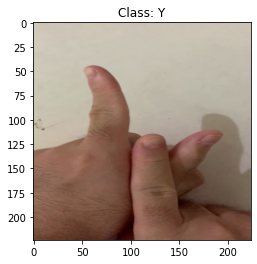

In [ ]:
check_index = 2
plt.imshow(x_train[check_index])
plt.title("Class: "+CLASSES[np.argmax(y_train[check_index])])
plt.show()

# Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 4

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

# Model

In [ ]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(27, activation='softmax'))
    
    return model

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 51kB 2.8MB/s 


In [ ]:
# from tensorflow.keras import layers
# def unfreeze_model(model):
#     # freeze all layers excluding top 20 layers
#     for layer in model.layers[:-20]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = False

In [ ]:
from tensorflow.keras import layers

def freeze_model(model):
  for layer in model.layers:
      layer.trainable = False

def unfreeze_model(model):
    # unfreeze top 20 layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

In [ ]:
efficientnetb0 = efn.EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False
                   )

# # coba unfreeze hanya top 20
freeze_model(efficientnetb0)
unfreeze_model(efficientnetb0)

# # coba freeze semua layer efficientnet
# freeze_model(efficientnetb0)

model = build_model(efficientnetb0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 27)                34587     
Total params: 4,089,271
Trainable params: 1,379,915
Non-trainable params: 2,709,356
_________________________________________________________________


In [ ]:
!pip install keras-rectified-adam
from keras_radam import RAdam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.19.0-cp37-none-any.whl size=9018 sha256=58458eae679d9232819614cfd2d10209814b66961a06b1283c0ee5b449eecabd
  Stored in directory: /root/.cache/pip/wheels/02/1e/17/465c89b2c5ce7670a3fc6c20c40e1dad994109d015d57a024e
Successfully built keras-rectified-adam


In [ ]:
model.compile(
        loss='categorical_crossentropy',
        optimizer = RAdam(learning_rate=1e-3, 
                          min_lr=1e-7,
                          warmup_proportion=0.15),
        metrics=['accuracy']
    )

In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/checkpoint'

In [ ]:
# Learning Rate Reducer
learn_control = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=5,
    verbose=1,
    factor=0.2, 
    min_lr=1e-7
)

# Checkpoint
checkpoint_filepath= CHECKPOINT_DIR + "/raw-batch4-epoch25-freezeall-weights.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_accuracy", 
                                        mode ="max", patience = 5, 
                                        restore_best_weights = True)

# Train Model

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
    epochs=25,
    validation_data=val_generator,
    validation_steps = x_val.shape[0] // BATCH_SIZE,
    callbacks=[learn_control, checkpoint, earlystopping]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
243/243 [==============================] - 28s 93ms/step - loss: 3.8185 - accuracy: 0.0566 - val_loss: 2.8469 - val_accuracy: 0.1991

Epoch 00001: val_accuracy improved from -inf to 0.19907, saving model to /content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/checkpoint/raw-batch4-epoch25-freezeall-weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
243/243 [==============================] - 22s 89ms/step - loss: 3.1797 - accuracy: 0.1492 - val_loss: 2.0830 - val_accuracy: 0.4151

Epoch 00002: val_accuracy improved from 0.19907 to 0.41512, saving model to /content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/checkpoint/raw-batch4-epoch25-freezeall-weights.hdf5
Epoch 3/25
243/243 [==============================] - 22s 89ms/step - loss: 2.7309 - accuracy: 0.2377 - val_loss: 1.5379 - val_accuracy: 0.5586

Epoch 00003: val_accuracy improved from 0.41512 to 0.55864, saving model to /content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/checkpoint/raw-batch4-epoch25-freezeall-weights.hdf5
Epoch 4/25
243/243 [==============================] - 22s 90ms/step - loss: 2.3067 - accuracy: 0.3241 - val_loss: 1.2172 - val_accuracy: 0.6389

Epoch 00004: val_accuracy improved from 0.55864 to 0.63889, saving model to /content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/checkpoint/raw-batch4-epoch25-freezeall-weights.hdf5
Epoc

In [ ]:
HISTORY_DIR = '/content/drive/MyDrive/Deep Learning/Proyek Final DL/Baru/history'

In [ ]:
with open(HISTORY_DIR + '/raw-batch4-epoch25-freezeall.json', 'w') as f:
    json.dump(str(history.history), f)

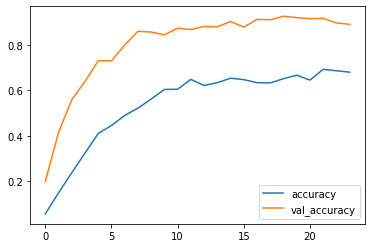

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

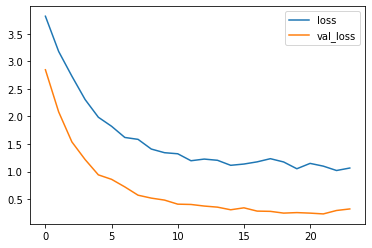

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Load Model

In [ ]:
model.load_weights('/content/drive/MyDrive/Kuliah/Semester 6/Deep Learning/Proyek Final DL/Baru/checkpoint/raw-batch4-epoch20-unfreezetop20-weights.hdf5')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 27)                34587     
Total params: 4,089,271
Trainable params: 1,379,915
Non-trainable params: 2,709,356
_________________________________________________________________


# Prediction

In [ ]:
val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.933641975308642

In [ ]:
test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.8123456790123457

4
(224, 224, 3)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


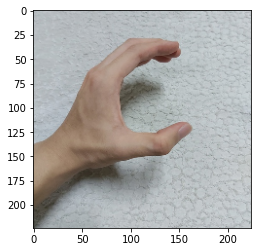

In [ ]:
print(len(test_generator[0][0]))
print(test_generator[13][0][3].shape)
print(test_generator[13][1][3])
plt.imshow(test_generator[13][0][3])
# print(test_generator[13][0][3])

# Evaluation

In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8123456790123457

# Save Model

In [ ]:
MODEL_DIR = '/content/drive/MyDrive/Deep Learning/Proyek Final DL/Colab/model'

In [ ]:
# # save model
# # serialize model to JSON
# model_json = model.to_json()

# with open(MODEL_DIR + "/efficientnetb0-coba-en-3-batch4-epoch30.json", "w") as json_file:
#     json_file.write(model_json)
    
# # serialize weights to HDF5
# model.save_weights(MODEL_DIR + "/efficientnet-coba-en-3-batch4-epoch30.h5")
# print("Model saved")

In [ ]:
DATASET_MANUAL_DIR = '/content/drive/MyDrive/Deep Learning/Proyek Final DL/Colab/Dataset manual'

In [ ]:
def Dataset_loader(DIR, RESIZE):
    IMG = []
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        img = cv2.imread(PATH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (RESIZE,RESIZE))
        IMG.append(np.array(img))
    return IMG

In [ ]:
manual_data = Dataset_loader(DATASET_MANUAL_DIR, 224)[0]

100%|██████████| 1/1 [00:00<00:00, 27.14it/s]


In [ ]:
def plot_result(data, pred_class):
  plt.imshow(data)
  plt.title("Predicted as "+pred_class)
  plt.show()  

In [ ]:
def predict_image(image):
    image = np.asarray(image).reshape(1, 224, 224, 3)
    prediction = CLASSES[np.argmax(model.predict(image), axis=-1)[0]]
    plot_result(image[0], prediction)

# Testing dari generator

(224, 224, 3)
NOTHING


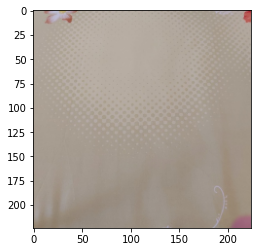

In [ ]:
# testing image dari generator
image_from_gen = test_generator[1][0][1]

plt.imshow(image_from_gen)
print(image_from_gen.shape)
print(CLASSES[np.argmax(model.predict(image_from_gen.reshape(1,224,224,3)))])

# Testing dari dataset asli

(224, 224, 3)
P


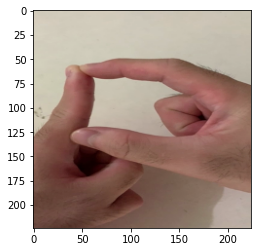

In [ ]:
# testing image dari dataset asli
image_from_dataset = x_train[1]

plt.imshow(image_from_dataset)
print(image_from_dataset.shape)
print(CLASSES[np.argmax(model.predict(image_from_dataset.reshape(1,224,224,3)/255))])

In [ ]:
def plot_result_with_labels(data, label, pred_class, row, col, index):
  plt.subplot(row, col, index)
  plt.imshow(data)
  plt.xticks([]), plt.yticks([])
  title = label+' -> '+pred_class+' ('
  if label == pred_class:
    title += 'CORRECT)'
    fontdict = {'color': 'green'}
  else:
    title += 'WRONG)'
    fontdict = {'color': 'red'}
  plt.title(title, fontdict=fontdict)

In [ ]:
def predict_image_with_labels(image, labels, row, col):
    actual = int(col*row / 27)
    results = dict()
    for CLASS in CLASSES:
       results[CLASS] = {'TP':actual,'TN':actual*26,'FP':0,'FN':0}
    #plt.figure(figsize=(3*col, 3*row))
    for i in range(1, col*row+1):
       img = np.asarray(image[i-1]).reshape(1, 224, 224, 3)/255
       prediction = CLASSES[np.argmax(model.predict(img), axis=-1)[0]]
       #plot_result_with_labels(img[0], labels[i-1], prediction, row, col, i)
       if labels[i-1] != prediction:
           results[labels[i-1]]['TP'] -= 1
           results[labels[i-1]]['FN'] += 1
           results[prediction]['TN'] -= 1
           results[prediction]['FP'] += 1

    TP = sum([x['TP'] for x in results.values()])
    TN = sum([x['TN'] for x in results.values()])
    FP = sum([x['FP'] for x in results.values()])
    FN = sum([x['FN'] for x in results.values()])

    acc = (TP+TN)/(TP+TN+FP+FN)
    recall = (TP)/(TP+FN)
    precision = (TP)/(TP+FP)
    if recall == 0 or precision == 0:
      f1 = 0
    else:
      f1 = (2)/((1/recall)+(1/precision))
    acc = round(acc, 2)
    recall = round(recall, 2)
    precision = round(precision, 2)
    f1 = round(f1, 2)

    print("==========Result for "+str(row*col)+" test data==========")
    print("--> Accuracy  = ",acc)
    print("--> Precision = ",recall)
    print("--> Recall    = ",precision)
    print("--> F1-Score  = ",f1)
    
    for key, val in results.items():
      TP = val['TP']
      TN = val['TN']
      FP = val['FP']
      FN = val['FN']
      acc = (TP+TN)/(TP+TN+FP+FN)
      recall = (TP)/(TP+FN)
      if TP+FP == 0:
        precision = 0
      else:
        precision = (TP)/(TP+FP)
      if recall == 0 or precision == 0:
        f1 = 0
      else:
        f1 = (2)/((1/recall)+(1/precision))
      acc = round(acc, 2)
      recall = round(recall, 2)
      precision = round(precision, 2)
      f1 = round(f1, 2)
      print(key+' ('+str(TP)+'/'+str(actual)+')-> Accuracy ('+str(acc)+'), Recall ('+str(recall)+'), Precision ('+str(precision)+'), F1-Score ('+str(f1)+')')

In [ ]:
import random

test_image = []
labels = []
for i in range(100):
  x = random.randrange(0, len(test_data))
  test_image.append(test_data[x])
  labels.append(CLASSES[test_labels[x]])

In [ ]:
predict_image_with_labels(test_image, labels, 10, 10)

Output hidden; open in https://colab.research.google.com to view.

## Seen Datatest: 

In [ ]:
fileName = DATASET_DIR + '/data_test_seen/raw'
fileObject = open(fileName, 'rb')

# dump information to that file
data_test_seen = pickle.load(fileObject)

# close the file
fileObject.close()

print(len(data_test_seen))

27


In [ ]:
data_test_seen = np.array(data_test_seen).reshape(-1, 224, 224, 3)

In [ ]:
print(data_test_seen.shape)

data_test_seen_char_labels = []
for i in range(len(CLASSES)):
    data_test_seen_char_labels.extend([CLASSES[i]]*12)

(324, 224, 224, 3)


In [ ]:
predict_image_with_labels(data_test_seen, data_test_seen_char_labels, 27, 12)

==========Result for 324 test data==========
--> Accuracy  =  0.99
--> Precision =  0.91
--> Recall    =  0.91
--> F1-Score  =  0.91
NOTHING (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
A (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
B (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
C (10/12)-> Accuracy (0.98), Recall (0.83), Precision (0.77), F1-Score (0.8)
D (12/12)-> Accuracy (0.98), Recall (1.0), Precision (0.67), F1-Score (0.8)
E (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
F (10/12)-> Accuracy (0.99), Recall (0.83), Precision (1.0), F1-Score (0.91)
G (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
H (11/12)-> Accuracy (1.0), Recall (0.92), Precision (1.0), F1-Score (0.96)
I (11/12)-> Accuracy (1.0), Recall (0.92), Precision (1.0), F1-Score (0.96)
J (12/12)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
K (9/12)-> Accuracy (0.99), Recall 

## Unseen Datatest: 

In [ ]:
data_test_unseen = test_data

In [ ]:
print(data_test_unseen.shape)

data_test_unseen_char_labels = []
for i in range(len(CLASSES)):
    data_test_unseen_char_labels.extend([CLASSES[i]]*15)

(405, 224, 224, 3)


In [ ]:
predict_image_with_labels(data_test_unseen, data_test_unseen_char_labels, 27, 15)

==========Result for 405 test data==========
--> Accuracy  =  0.99
--> Precision =  0.81
--> Recall    =  0.81
--> F1-Score  =  0.81
NOTHING (15/15)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
A (15/15)-> Accuracy (1.0), Recall (1.0), Precision (0.94), F1-Score (0.97)
B (15/15)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
C (15/15)-> Accuracy (0.95), Recall (1.0), Precision (0.43), F1-Score (0.6)
D (13/15)-> Accuracy (0.99), Recall (0.87), Precision (0.81), F1-Score (0.84)
E (9/15)-> Accuracy (0.99), Recall (0.6), Precision (1.0), F1-Score (0.75)
F (10/15)-> Accuracy (0.99), Recall (0.67), Precision (1.0), F1-Score (0.8)
G (15/15)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
H (0/15)-> Accuracy (0.96), Recall (0.0), Precision (0), F1-Score (0)
I (5/15)-> Accuracy (0.98), Recall (0.33), Precision (1.0), F1-Score (0.5)
J (15/15)-> Accuracy (1.0), Recall (1.0), Precision (1.0), F1-Score (1.0)
K (6/15)-> Accuracy (0.98), Recall (0.4